In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using CairoMakie
#using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2,  el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [4]:
function Tr(x, drop_size = 2)
    println("variable before truncate length: ", length(x)); flush(stdout)
    x = x[floor(Int, length(x) / drop_size):end ]
    println("variable  after truncate length: ", length(x)); flush(stdout)
    return x
end
Hs(x) = Statistics.mean(x) + 6 * Statistics.std(x)
function calc_number_EEs(x)
    threshold = Hs(x)
    counts = length(x[x.>=threshold])
    return counts
end

calc_number_EEs (generic function with 1 method)

In [36]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.300
tspan = (0.0, 20000.0)

p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[-0.1, -0.1, -0.1, -0.6, -0.1, -0.1]

6-element SVector{6, Float64} with indices SOneTo(6):
 -0.1
 -0.1
 -0.1
 -0.6
 -0.1
 -0.1

In [39]:
prob = ODEProblem(HR, condition, tspan, p)
sol = solve(prob, RK4(), dt = 0.001);

In [40]:
xsum = sol[1, :] + sol[4, :];
xsum = Tr(xsum)

Hs_ = Hs(xsum)

variable before truncate length: 115498
variable  after truncate length: 57750


3.2159520451471715

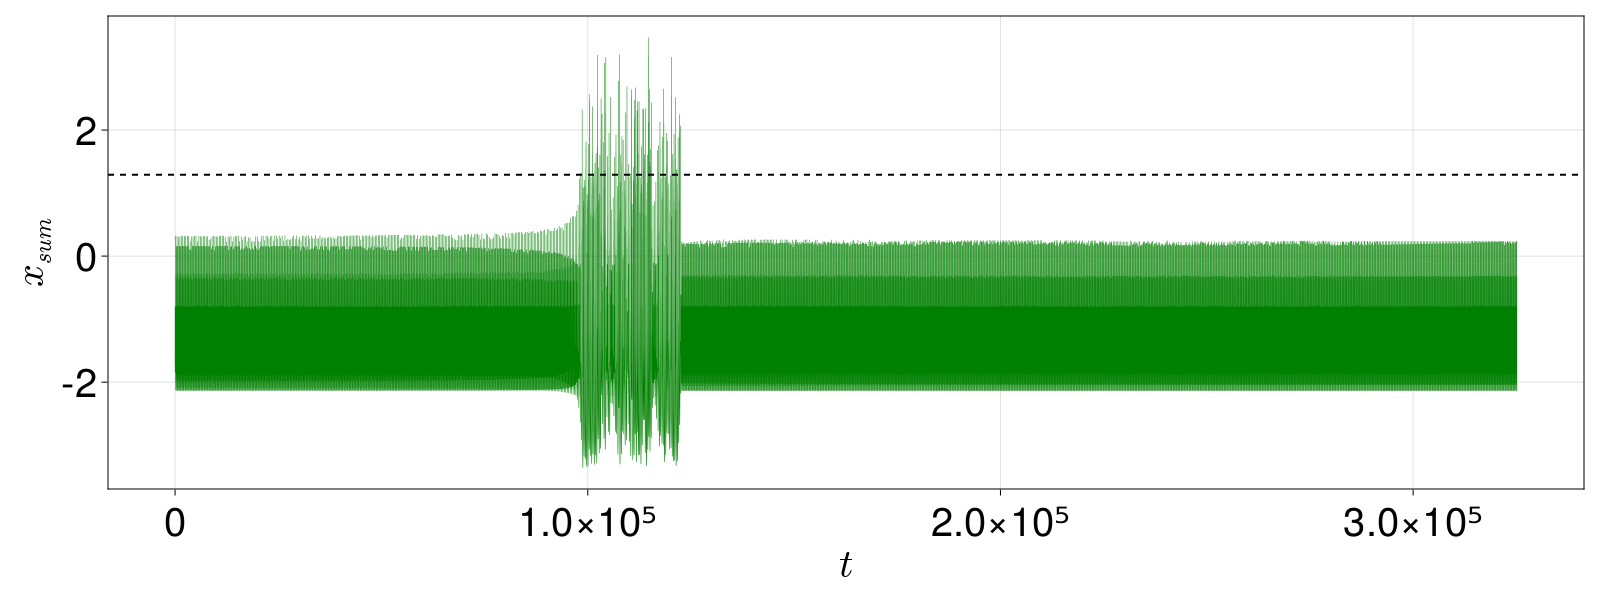

In [35]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
lines!(ax, xsum[1:end], linewidth = 0.5, color = "green")
hlines!(Hs_, color = "black", linewidth = 2.0, linestyle = :dash)
f

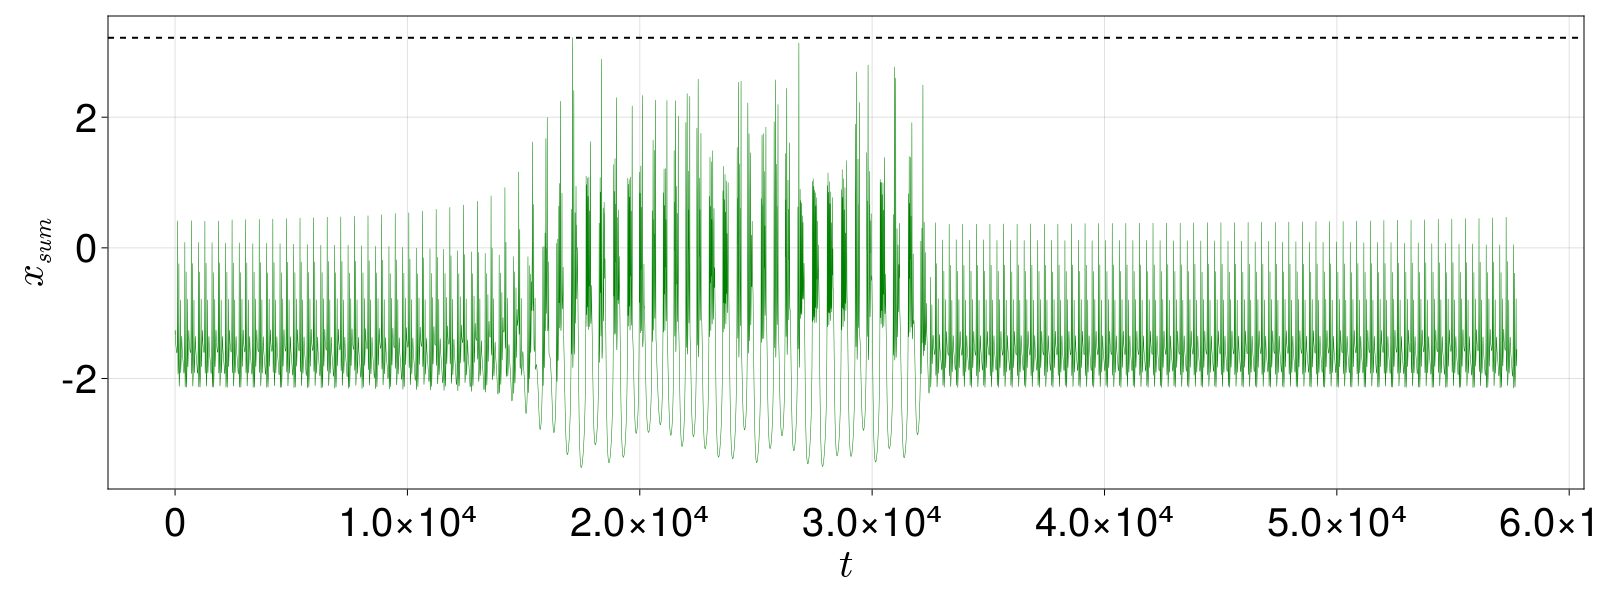

In [41]:
f = Figure(resolution = (1600, 600), fontsize = 40)
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")
lines!(ax, xsum[1:end], linewidth = 0.5, color = "green")
hlines!(Hs_, color = "black", linewidth = 2.0, linestyle = :dash)
f

In [ ]:
ts, tf = 1524371, 2524371

f = Figure(resolution = (2500, 2500), dpi = 300)
ax = Axis3(f[1, 1],
xlabel = L"x_1", ylabel = L"y_1", zlabel = L"z_1",
xlabelsize = 100, ylabelsize = 100, zlabelsize = 100,
xticklabelsize = 50, yticklabelsize = 50, zticklabelsize = 50,
zticks = range(3.6, 4.2, step = 0.2))
lines!(ax, sol[1, ts:tf], sol[2, ts:tf], sol[3, ts:tf], linewidth = 1.5, color = "blue" )
f

In [ ]:
ds = ContinuousDynamicalSystem(HR, condition, p)

In [ ]:
LES = lyapunovspectrum(ds, tspan[2]; Ttr = tspan[2]/4, Δt = 1,
                        diffeq = (alg = Vern9(), adaptive = false, dense = false, dt = 0.001)
)
    

In [ ]:
LES = lyapunovspectrum(ds, tspan[2]; Ttr = tspan[2]/4)
    